In [1]:
%matplotlib inline
import json
import pandas as pd
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import sklearn
import sys
import json
import os
import sklearn.linear_model
from sklearn import preprocessing
from sklearn.decomposition import PCA

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import statsmodels.stats.weightstats

In [2]:
os.chdir("C:\\Users\\alexh\\Documents\\Beng_182-203_Scripts\\Project\\FPKM_KIRP_Data")


In [3]:
import filesToExceGZ


In [5]:

#Takes in a data frame with file names and swaps the file names for case_ids
#Also removes samples that were not from the primary tumor.
#Param:
#df: The df with column names to switch
#gdcSampleFile (aka sample sheet from GDC): The gdcSample file to convert file name to sample ID
#sampleFile (AKA GDC Biospecimen): File needed to convert sample ID to case_ID
def fileNameToID (df, gdcSampleFile,sampleFile):
    newcolumns = list(df.columns)
    
    for i in range(len(newcolumns)):
        if "." in newcolumns[i]:
            newcolumns[i] = newcolumns[i] + ".txt.gz"
            
    print(len(newcolumns))
    dropDict = makeConversionDict(gdcSampleFile,1,7)
    for i in dropDict:
        if dropDict[i] != "Primary Tumor":
            df = df.drop(i.split(".txt")[0],axis =1)
            newcolumns.remove(i)
    
    fileNameToSampleIDdict = makeConversionDict(gdcSampleFile,1,6)

    newcolumns = updateColumns(newcolumns, fileNameToSampleIDdict)
    
    #print(newcolumns)
    print(len(newcolumns))
    sampleIDtoCaseIDdict = makeConversionDict(sampleFile,1, 2)
    newcolumns = updateColumns(newcolumns, sampleIDtoCaseIDdict)
    
    print(len(newcolumns))
    print(df.shape)
    df.columns = newcolumns

    return df

#Helper function: Makes a conversion dictionary given an tsv or csv file to convert names
def makeConversionDict(file, col1, col2, sep = "\t"):
    data = open(file,"r").readlines()
    
    header = data[0].strip().split(sep)
    if type(col1) != int:
        for i in range(len(header)):
            if col1 == header[i]:
                col1 = i
            break
    
    if type(col1) != int:
        print (header)
        print(col1)
    
    
    if type(col2) != int:
        for i in range(len(header)):
            if col2 == header[i]:
                col2 = i
            break
            
    if type(col2) != int:
        print (header)
        print(col2)
    
    conversionDict = {} 
    for i in data[1:]:
        i = i.strip().split(sep)
        conversionDict[i[col1]]= i[col2]
    #print (conversionDict)
    return conversionDict
    
#Helper funciton. Updates columns of a data frame using a conversion dict
def updateColumns(columns, conversionDict):
    newColumns = []
    for i in columns:
        
        #if lenght columns < 5 then its mean,var or cv column, keep the same
        if len(i) < 5:
            newColumns.append(i)
            continue
        if i in conversionDict:
            newColumns.append(conversionDict[i])
        else:
            #print(i)
            continue
    return newColumns


In [7]:
#Adds clincal data to a data frame that has had its column names converted.
def addClin (df,clinFile = "clinical.tsv.txt"):
    clinicalDF = pd.read_csv(clinFile, sep = "\t", header = 0)
    clinicalDF.head()
    clinID = list(clinicalDF.loc[:,"case_id"])
    deathDate = list(clinicalDF.loc[:,"days_to_death"])
    deathDict ={}
    for i in range(len(clinID)):
        deathDict[clinID[i]] = deathDate[i]
        
    for ID in clinID:
        if ID not in df.columns:
            #print(ID)
            continue
        ddate = np.nan
        try:
            ddate = int(deathDict[ID])
        except:
            pass

        df.loc["Death_Date",ID] = ddate

        if np.isnan(ddate):
             df.loc["Dead",ID] = 0
        else:
            df.loc["Dead",ID] = 1
    return df

## Preprocessing: Getting Case_IDS and Getting Clinical Data

In this step, the data frame is read as a pandas data frame. The column names are then switched to case_id's using the functions above. After the case_id's are retrived the clical data is added to the data frame. The data frame will then be ready for analysis.

In [8]:
#Preprocessing: Change column names and add clincal data
bfdfOrg = pd.read_csv("TCGA-KIRP_min_1_var_1_mean.txt", sep = "\t",header = 0, index_col = 0)

In [9]:
bfdfOrg.head()

,3a8bb200-5964-4ae2-a656-c1dc40c29d71.FPKM-UQ,b0b535b6-6600-4d7c-a22e-46b8478fe651.FPKM-UQ,0fef447c-5f07-4299-b602-2b6b8450c6e6.FPKM-UQ,73e6cc52-f4fe-4168-9dd0-d6d28879cc95.FPKM-UQ,a4bf31ea-aae7-45d1-9728-cf40d4c4b7da.FPKM-UQ,9792f7ee-3295-43d7-b2f9-46cfa2dd2167.FPKM-UQ,521cf209-e415-4352-96d7-aef7c1d564c0.FPKM-UQ,6a058f09-eac6-40d3-a24f-da1cb0371a2b.FPKM-UQ,55cca3e8-899a-4fba-941a-8789f5d1d206.FPKM-UQ,5dc059dd-6aa0-4d5b-b447-b5be0a9021ad.FPKM-UQ,...,09246213-2ca8-461d-8cb9-2de1da038b7f.FPKM-UQ,d1c52e51-385b-44d4-b119-6ee3883017f8.FPKM-UQ,5dddcbc8-e340-4c24-96eb-6fa7ff9d757a.FPKM-UQ,c111fbd6-cfcb-4372-b630-f3688e26427f.FPKM-UQ,ace931f9-743c-4699-9198-2a93bf20b6aa.FPKM-UQ,543ed507-fee0-40b6-9a99-e59310620d63.FPKM-UQ,f0532052-b496-4435-abc4-93e23c6a68a5.FPKM-UQ,151836ff-610c-49ac-a8c5-868e0bbf4eaa.FPKM-UQ,var,mean
ENSG00000242268.2,478.170329,0.000000,2424.392296,1683.994266,3024.589916,1025.819887,18494.807227,5531.470611,4417.975860,2768.453473,...,1341.541330,1729.486667,25733.520208,6123.698714,21024.357443,6867.405756,1056.602179,1997.979543,5.856147e+07,9.970649e+04
ENSG00000270112.3,729.824168,0.000000,134.556852,0.000000,419.671456,1992.700737,394.802036,143.907959,122.601636,192.065856,...,0.000000,119.985884,127.521702,0.000000,402.371912,250.756410,73.303454,138.613003,8.551813e+07,1.414011e+05
ENSG00000167578.15,41564.503431,46993.977780,41098.283419,52842.431197,264182.346547,43659.227887,100189.089267,56236.734957,122219.817840,82628.175084,...,41491.689127,53334.258625,63065.052721,157553.938296,118583.688461,68702.517594,66405.984275,53506.978190,1.972458e+09,3.292414e+06
ENSG00000273842.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9651.578033,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.764618e+06,3.055982e+03
ENSG00000078237.5,80972.601107,72836.085425,69467.701177,82266.712935,59434.575911,51077.211155,80360.335074,84607.438537,59145.048978,86316.129981,...,140369.245949,47931.324161,98429.711527,76946.310173,56019.707018,64771.483892,120109.418688,78366.005437,1.160801e+09,1.977092e+06


In [10]:
bfdfOrg = fileNameToID(bfdfOrg, "Meta_data/gdc_sample_sheet.2018-05-31.tsv","Meta_data/sample.tsv")
bfdfOrg.head()

613
540
540
(58200, 540)


,f00b7956-73a9-4e4b-85d2-60b3ba13f4a4,9816ac2a-0412-4649-a9da-8fd91b1eb8e1,351fb9f4-a3b6-44d8-9fdc-5b0b582fda23,1b0ad45e-b917-4e91-83c4-e5386cdf0eee,33cd8b05-2b9b-40dd-97a2-40d02e27ee90,2304b8f8-4cb4-46c5-a88e-c78d97b06d6b,e4769374-7d4d-4aaf-b6fe-a01da59ee713,31e9d2fc-79fa-49db-adac-7afb9609f915,d65f7f50-2cb0-45e7-866a-ba5c498aef52,a55e63a9-5046-4f0f-a1e1-197b783d5387,...,d5213422-9447-4f62-b486-3303e3f991fa,11111b58-c7df-4291-ad8a-4baec9ff7d1f,659294b9-ded9-498a-bc00-c1d4d456aa4a,b15f495d-8598-4404-86b0-519df0f2d504,ce0ab696-4e50-4b05-a7e5-5191c257bfbe,9868ae73-3459-4aa6-b71a-39953cdbbe1a,e9f855b3-291b-449d-9758-caa0f99fa76d,2efcefca-5e52-4b3d-a48a-9e9c73cc0141,var,mean
ENSG00000242268.2,0.000000,2424.392296,1683.994266,3024.589916,18494.807227,5531.470611,4417.975860,2768.453473,1782.848993,3139.858258,...,1341.541330,1729.486667,25733.520208,6123.698714,21024.357443,6867.405756,1056.602179,1997.979543,5.856147e+07,9.970649e+04
ENSG00000270112.3,0.000000,134.556852,0.000000,419.671456,394.802036,143.907959,122.601636,192.065856,61.843990,248.951603,...,0.000000,119.985884,127.521702,0.000000,402.371912,250.756410,73.303454,138.613003,8.551813e+07,1.414011e+05
ENSG00000167578.15,46993.977780,41098.283419,52842.431197,264182.346547,100189.089267,56236.734957,122219.817840,82628.175084,61571.009218,44975.886130,...,41491.689127,53334.258625,63065.052721,157553.938296,118583.688461,68702.517594,66405.984275,53506.978190,1.972458e+09,3.292414e+06
ENSG00000273842.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9651.578033,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.764618e+06,3.055982e+03
ENSG00000078237.5,72836.085425,69467.701177,82266.712935,59434.575911,80360.335074,84607.438537,59145.048978,86316.129981,68253.097560,63420.358989,...,140369.245949,47931.324161,98429.711527,76946.310173,56019.707018,64771.483892,120109.418688,78366.005437,1.160801e+09,1.977092e+06


In [11]:
bfdfOrg = addClin(bfdfOrg)
bfdfOrg.tail()

,f00b7956-73a9-4e4b-85d2-60b3ba13f4a4,9816ac2a-0412-4649-a9da-8fd91b1eb8e1,351fb9f4-a3b6-44d8-9fdc-5b0b582fda23,1b0ad45e-b917-4e91-83c4-e5386cdf0eee,33cd8b05-2b9b-40dd-97a2-40d02e27ee90,2304b8f8-4cb4-46c5-a88e-c78d97b06d6b,e4769374-7d4d-4aaf-b6fe-a01da59ee713,31e9d2fc-79fa-49db-adac-7afb9609f915,d65f7f50-2cb0-45e7-866a-ba5c498aef52,a55e63a9-5046-4f0f-a1e1-197b783d5387,...,d5213422-9447-4f62-b486-3303e3f991fa,11111b58-c7df-4291-ad8a-4baec9ff7d1f,659294b9-ded9-498a-bc00-c1d4d456aa4a,b15f495d-8598-4404-86b0-519df0f2d504,ce0ab696-4e50-4b05-a7e5-5191c257bfbe,9868ae73-3459-4aa6-b71a-39953cdbbe1a,e9f855b3-291b-449d-9758-caa0f99fa76d,2efcefca-5e52-4b3d-a48a-9e9c73cc0141,var,mean
ENSG00000280861.1,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,3.342572e+06,5.540277e+03
ENSG00000123685.7,11722.919773,15227.292562,47816.62303,25857.103619,75953.043148,25604.459772,72146.701994,36044.48868,50740.22405,12325.650736,...,21065.116356,14709.880146,6133.23921,39530.548032,36048.474383,19674.830389,58759.621715,23137.310099,8.818785e+08,1.474177e+06
ENSG00000181518.3,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,471.339273,0.00000,0.00000,0.000000,...,0.000000,0.000000,0.00000,0.000000,773.454949,0.000000,0.000000,0.000000,9.529985e+04,2.268784e+02
Death_Date,NaN,NaN,2241.00000,1724.000000,1714.000000,561.000000,2386.000000,1378.00000,NaN,NaN,...,1432.000000,480.000000,NaN,NaN,1097.000000,1170.000000,222.000000,1404.000000,NaN,NaN
Dead,0.000000,0.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.00000,0.00000,0.000000,...,1.000000,1.000000,0.00000,0.000000,1.000000,1.000000,1.000000,1.000000,NaN,NaN


## Filtering and getting Z-scores:
During this step the data is filtered to remove some bad data and some confounding cases. First, any one who was reported as dead but lived for more than 3 years was removed as it is hard to tell whether they belong in high or low risk category. The mean, std, coeficient of variation (CV) and number of zeros in the data set were analyzed for filtering. Any gene with more than 450 zeros was removed as that there are too few variables left to make good predictions with. Transcripts with CV < 1 were also removed as there are too few variables to make good predictions. Finally the Z-score between those who lived and hotse who died was calculated for each gene and the results written to file.

In [12]:
bfdfOrg = bfdfOrg.loc[:,bfdfOrg.loc["Dead", :] ==0 |(bfdfOrg.loc["Death_Date", :]<1095)]

In [13]:
bfdfOrg.loc[:,"std"] = bfdfOrg.iloc[:-2,:].std(axis =1)
bfdfOrg.loc[:,"mean"] = bfdfOrg.iloc[:-2,:-1].mean(axis =1)
bfdfOrg.loc[:, "zeros"] = (bfdfOrg.iloc[:-2,:-2] == 0).astype(int).sum(axis=1)

bfdfOrg.tail()

,f00b7956-73a9-4e4b-85d2-60b3ba13f4a4,9816ac2a-0412-4649-a9da-8fd91b1eb8e1,2304b8f8-4cb4-46c5-a88e-c78d97b06d6b,d65f7f50-2cb0-45e7-866a-ba5c498aef52,a55e63a9-5046-4f0f-a1e1-197b783d5387,6b033bf5-4ad9-419f-9d2c-63e2e8c80066,1e758394-67fb-45cb-98b0-5082c396d697,44143697-c4b3-4051-9594-d53131c05889,75e02a42-6937-4761-868b-c369c7bd3c72,822cf6c1-dd65-4814-94b1-0c335208ad9b,...,424e5c99-3693-4b10-bbf0-fc43e851610c,c6454371-1f84-4e8e-8c3a-2eac8380819e,3f93d1cf-a307-4e29-9e6f-239e9ffaa179,11111b58-c7df-4291-ad8a-4baec9ff7d1f,659294b9-ded9-498a-bc00-c1d4d456aa4a,b15f495d-8598-4404-86b0-519df0f2d504,e9f855b3-291b-449d-9758-caa0f99fa76d,std,mean,zeros
ENSG00000280861.1,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,2075.669734,101.429113,472.0
ENSG00000123685.7,11722.919773,15227.292562,25604.459772,50740.22405,12325.650736,16152.700451,45054.673267,98714.157671,3008.944086,83389.412197,...,26568.731169,29330.057706,11082.774629,14709.880146,6133.23921,39530.548032,58759.621715,30437.146236,36423.378021,0.0
ENSG00000181518.3,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,429.138827,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,340.549549,78.593950,417.0
Death_Date,NaN,NaN,561.000000,NaN,NaN,1091.000000,307.000000,NaN,NaN,574.000000,...,NaN,NaN,NaN,480.000000,NaN,NaN,222.000000,NaN,NaN,NaN
Dead,0.000000,0.000000,1.000000,0.00000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,1.000000,NaN,NaN,NaN


In [14]:
bfdfOrg.loc[:,"CV"] = bfdfOrg.iloc[:-2,-3]/bfdfOrg.iloc[:-2,-2]

In [15]:
bfdfOrg.tail()

,f00b7956-73a9-4e4b-85d2-60b3ba13f4a4,9816ac2a-0412-4649-a9da-8fd91b1eb8e1,2304b8f8-4cb4-46c5-a88e-c78d97b06d6b,d65f7f50-2cb0-45e7-866a-ba5c498aef52,a55e63a9-5046-4f0f-a1e1-197b783d5387,6b033bf5-4ad9-419f-9d2c-63e2e8c80066,1e758394-67fb-45cb-98b0-5082c396d697,44143697-c4b3-4051-9594-d53131c05889,75e02a42-6937-4761-868b-c369c7bd3c72,822cf6c1-dd65-4814-94b1-0c335208ad9b,...,c6454371-1f84-4e8e-8c3a-2eac8380819e,3f93d1cf-a307-4e29-9e6f-239e9ffaa179,11111b58-c7df-4291-ad8a-4baec9ff7d1f,659294b9-ded9-498a-bc00-c1d4d456aa4a,b15f495d-8598-4404-86b0-519df0f2d504,e9f855b3-291b-449d-9758-caa0f99fa76d,std,mean,zeros,CV
ENSG00000280861.1,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,2075.669734,101.429113,472.0,20.464240
ENSG00000123685.7,11722.919773,15227.292562,25604.459772,50740.22405,12325.650736,16152.700451,45054.673267,98714.157671,3008.944086,83389.412197,...,29330.057706,11082.774629,14709.880146,6133.23921,39530.548032,58759.621715,30437.146236,36423.378021,0.0,0.835649
ENSG00000181518.3,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,429.138827,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,340.549549,78.593950,417.0,4.333025
Death_Date,NaN,NaN,561.000000,NaN,NaN,1091.000000,307.000000,NaN,NaN,574.000000,...,NaN,NaN,480.000000,NaN,NaN,222.000000,NaN,NaN,NaN,NaN
Dead,0.000000,0.000000,1.000000,0.00000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,1.000000,0.00000,0.000000,1.000000,NaN,NaN,NaN,NaN


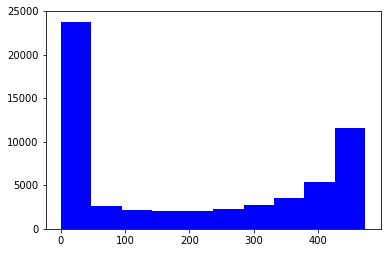

In [16]:
#plt.xlim(xmin =bfdfOrg.iloc[:-2,-1].min(), xmax= bfdfOrg.iloc[:-2,-1].max())
plt.hist(bfdfOrg.iloc[:-2,-2], facecolor='blue')
plt.show()

In [17]:
(bfdfOrg.iloc[:-2,-1] <1).astype(int).sum()

14977

In [18]:
(bfdfOrg.iloc[-1,:-4]).astype(int).sum()

109

In [19]:
bfdfOrg = bfdfOrg.loc[bfdfOrg.iloc[:,-2] < 450,:]
bfdfOrg.tail()

,f00b7956-73a9-4e4b-85d2-60b3ba13f4a4,9816ac2a-0412-4649-a9da-8fd91b1eb8e1,2304b8f8-4cb4-46c5-a88e-c78d97b06d6b,d65f7f50-2cb0-45e7-866a-ba5c498aef52,a55e63a9-5046-4f0f-a1e1-197b783d5387,6b033bf5-4ad9-419f-9d2c-63e2e8c80066,1e758394-67fb-45cb-98b0-5082c396d697,44143697-c4b3-4051-9594-d53131c05889,75e02a42-6937-4761-868b-c369c7bd3c72,822cf6c1-dd65-4814-94b1-0c335208ad9b,...,c6454371-1f84-4e8e-8c3a-2eac8380819e,3f93d1cf-a307-4e29-9e6f-239e9ffaa179,11111b58-c7df-4291-ad8a-4baec9ff7d1f,659294b9-ded9-498a-bc00-c1d4d456aa4a,b15f495d-8598-4404-86b0-519df0f2d504,e9f855b3-291b-449d-9758-caa0f99fa76d,std,mean,zeros,CV
ENSG00000273233.1,0.000000,0.000000,0.000000,0.000000,0.000000,1142.991036,5363.227966,1919.589361,0.000000,0.000000,...,1858.604783,793.046568,1441.238889,765.878578,1701.027421,880.501816,2109.140428,1295.121041,204.0,1.628528
ENSG00000105063.17,202727.719113,222309.739359,202280.893252,255789.269253,251419.647790,285802.278116,261427.422795,302725.919893,54314.297495,150311.440072,...,284087.868065,249208.649634,266833.021496,216633.927074,216411.617980,207062.247105,81153.281352,282853.691105,0.0,0.286909
ENSG00000231119.2,3380.988364,1712.754756,4613.381030,1049.604299,3344.917310,1614.972409,2525.964747,9944.937256,4512.584470,4333.799449,...,4595.654612,2988.062690,4412.150894,9919.588211,7210.325186,829.394745,20769.849012,6888.664601,3.0,3.015076
ENSG00000123685.7,11722.919773,15227.292562,25604.459772,50740.224050,12325.650736,16152.700451,45054.673267,98714.157671,3008.944086,83389.412197,...,29330.057706,11082.774629,14709.880146,6133.239210,39530.548032,58759.621715,30437.146236,36423.378021,0.0,0.835649
ENSG00000181518.3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,429.138827,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,340.549549,78.593950,417.0,4.333025


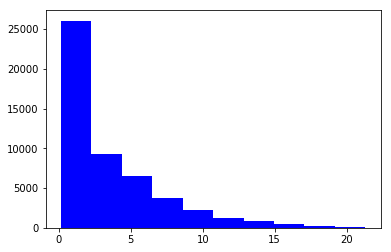

In [20]:
plt.hist(bfdfOrg.iloc[:-2,-1], facecolor='blue')
plt.show()

In [21]:
bfdfOrg = bfdfOrg.loc[bfdfOrg.iloc[:,-1] >1,:]
bfdfOrg.tail()

,f00b7956-73a9-4e4b-85d2-60b3ba13f4a4,9816ac2a-0412-4649-a9da-8fd91b1eb8e1,2304b8f8-4cb4-46c5-a88e-c78d97b06d6b,d65f7f50-2cb0-45e7-866a-ba5c498aef52,a55e63a9-5046-4f0f-a1e1-197b783d5387,6b033bf5-4ad9-419f-9d2c-63e2e8c80066,1e758394-67fb-45cb-98b0-5082c396d697,44143697-c4b3-4051-9594-d53131c05889,75e02a42-6937-4761-868b-c369c7bd3c72,822cf6c1-dd65-4814-94b1-0c335208ad9b,...,c6454371-1f84-4e8e-8c3a-2eac8380819e,3f93d1cf-a307-4e29-9e6f-239e9ffaa179,11111b58-c7df-4291-ad8a-4baec9ff7d1f,659294b9-ded9-498a-bc00-c1d4d456aa4a,b15f495d-8598-4404-86b0-519df0f2d504,e9f855b3-291b-449d-9758-caa0f99fa76d,std,mean,zeros,CV
ENSG00000216352.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,423.412734,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,184.179922,37.449353,436.0,4.918107
ENSG00000267117.1,693.447613,1561.286649,2782.981954,717.586613,2166.471684,7728.796530,14247.214427,3708.594413,0.00000,2539.631747,...,2693.080399,766.072195,4176.651474,739.828286,6572.677380,6804.422194,45803.918832,6756.218795,84.0,6.779520
ENSG00000273233.1,0.000000,0.000000,0.000000,0.000000,0.000000,1142.991036,5363.227966,1919.589361,0.00000,0.000000,...,1858.604783,793.046568,1441.238889,765.878578,1701.027421,880.501816,2109.140428,1295.121041,204.0,1.628528
ENSG00000231119.2,3380.988364,1712.754756,4613.381030,1049.604299,3344.917310,1614.972409,2525.964747,9944.937256,4512.58447,4333.799449,...,4595.654612,2988.062690,4412.150894,9919.588211,7210.325186,829.394745,20769.849012,6888.664601,3.0,3.015076
ENSG00000181518.3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,429.138827,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,340.549549,78.593950,417.0,4.333025


In [22]:
bfdfOrg.shape

(35887, 478)

In [23]:
bfdfOrg = addClin(bfdfOrg)
bfdfOrg.tail()

,f00b7956-73a9-4e4b-85d2-60b3ba13f4a4,9816ac2a-0412-4649-a9da-8fd91b1eb8e1,2304b8f8-4cb4-46c5-a88e-c78d97b06d6b,d65f7f50-2cb0-45e7-866a-ba5c498aef52,a55e63a9-5046-4f0f-a1e1-197b783d5387,6b033bf5-4ad9-419f-9d2c-63e2e8c80066,1e758394-67fb-45cb-98b0-5082c396d697,44143697-c4b3-4051-9594-d53131c05889,75e02a42-6937-4761-868b-c369c7bd3c72,822cf6c1-dd65-4814-94b1-0c335208ad9b,...,c6454371-1f84-4e8e-8c3a-2eac8380819e,3f93d1cf-a307-4e29-9e6f-239e9ffaa179,11111b58-c7df-4291-ad8a-4baec9ff7d1f,659294b9-ded9-498a-bc00-c1d4d456aa4a,b15f495d-8598-4404-86b0-519df0f2d504,e9f855b3-291b-449d-9758-caa0f99fa76d,std,mean,zeros,CV
ENSG00000273233.1,0.000000,0.000000,0.00000,0.000000,0.00000,1142.991036,5363.227966,1919.589361,0.00000,0.000000,...,1858.604783,793.046568,1441.238889,765.878578,1701.027421,880.501816,2109.140428,1295.121041,204.0,1.628528
ENSG00000231119.2,3380.988364,1712.754756,4613.38103,1049.604299,3344.91731,1614.972409,2525.964747,9944.937256,4512.58447,4333.799449,...,4595.654612,2988.062690,4412.150894,9919.588211,7210.325186,829.394745,20769.849012,6888.664601,3.0,3.015076
ENSG00000181518.3,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,429.138827,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,340.549549,78.593950,417.0,4.333025
Death_Date,NaN,NaN,561.00000,NaN,NaN,1091.000000,307.000000,NaN,NaN,574.000000,...,NaN,NaN,480.000000,NaN,NaN,222.000000,NaN,NaN,NaN,NaN
Dead,0.000000,0.000000,1.00000,0.000000,0.00000,1.000000,1.000000,0.000000,0.00000,1.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,NaN,NaN,NaN,NaN


In [24]:
aliveMean = bfdfOrg.loc[bfdfOrg.index[:-2],(bfdfOrg.iloc[-1,:] == 0)].mean(axis =1)
deadMean = bfdfOrg.loc[bfdfOrg.index[:-2],(bfdfOrg.iloc[-1,:] == 1)].mean(axis =1)
aliveStd = bfdfOrg.loc[bfdfOrg.index[:-2],(bfdfOrg.iloc[-1,:] == 0)].std(axis =1)


In [25]:
bfdfOrg.loc[:,"Z-Score"] =  (deadMean-aliveMean)/aliveStd

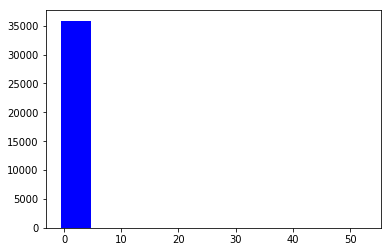

In [26]:
plt.hist(bfdfOrg.iloc[:-2,-1], facecolor='blue')
plt.show()

In [27]:
(bfdfOrg.iloc[:-2,-1] >1.96).astype(int).sum()

126

In [28]:
bfdfOrg.tail()

,f00b7956-73a9-4e4b-85d2-60b3ba13f4a4,9816ac2a-0412-4649-a9da-8fd91b1eb8e1,2304b8f8-4cb4-46c5-a88e-c78d97b06d6b,d65f7f50-2cb0-45e7-866a-ba5c498aef52,a55e63a9-5046-4f0f-a1e1-197b783d5387,6b033bf5-4ad9-419f-9d2c-63e2e8c80066,1e758394-67fb-45cb-98b0-5082c396d697,44143697-c4b3-4051-9594-d53131c05889,75e02a42-6937-4761-868b-c369c7bd3c72,822cf6c1-dd65-4814-94b1-0c335208ad9b,...,3f93d1cf-a307-4e29-9e6f-239e9ffaa179,11111b58-c7df-4291-ad8a-4baec9ff7d1f,659294b9-ded9-498a-bc00-c1d4d456aa4a,b15f495d-8598-4404-86b0-519df0f2d504,e9f855b3-291b-449d-9758-caa0f99fa76d,std,mean,zeros,CV,Z-Score
ENSG00000273233.1,0.000000,0.000000,0.00000,0.000000,0.00000,1142.991036,5363.227966,1919.589361,0.00000,0.000000,...,793.046568,1441.238889,765.878578,1701.027421,880.501816,2109.140428,1295.121041,204.0,1.628528,0.491423
ENSG00000231119.2,3380.988364,1712.754756,4613.38103,1049.604299,3344.91731,1614.972409,2525.964747,9944.937256,4512.58447,4333.799449,...,2988.062690,4412.150894,9919.588211,7210.325186,829.394745,20769.849012,6888.664601,3.0,3.015076,-0.076638
ENSG00000181518.3,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,429.138827,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,340.549549,78.593950,417.0,4.333025,-0.109504
Death_Date,NaN,NaN,561.00000,NaN,NaN,1091.000000,307.000000,NaN,NaN,574.000000,...,NaN,480.000000,NaN,NaN,222.000000,NaN,NaN,NaN,NaN,NaN
Dead,0.000000,0.000000,1.00000,0.000000,0.00000,1.000000,1.000000,0.000000,0.00000,1.000000,...,0.000000,1.000000,0.000000,0.000000,1.000000,NaN,NaN,NaN,NaN,NaN


In [80]:
from scipy import stats

In [94]:
Pvals = list(stats.norm.sf(abs(bfdfOrg.iloc[:-2,-2]))*2)
Pvals.append(None)
Pvals.append(None)
bfdfOrg.loc[:,"P-Values"] = Pvals

In [95]:
bfdfOrg.tail()

,f00b7956-73a9-4e4b-85d2-60b3ba13f4a4,9816ac2a-0412-4649-a9da-8fd91b1eb8e1,2304b8f8-4cb4-46c5-a88e-c78d97b06d6b,d65f7f50-2cb0-45e7-866a-ba5c498aef52,a55e63a9-5046-4f0f-a1e1-197b783d5387,6b033bf5-4ad9-419f-9d2c-63e2e8c80066,1e758394-67fb-45cb-98b0-5082c396d697,44143697-c4b3-4051-9594-d53131c05889,75e02a42-6937-4761-868b-c369c7bd3c72,822cf6c1-dd65-4814-94b1-0c335208ad9b,...,11111b58-c7df-4291-ad8a-4baec9ff7d1f,659294b9-ded9-498a-bc00-c1d4d456aa4a,b15f495d-8598-4404-86b0-519df0f2d504,e9f855b3-291b-449d-9758-caa0f99fa76d,std,mean,zeros,CV,Z-Score,P-Values
ENSG00000273233.1,0.000000,0.000000,0.00000,0.000000,0.00000,1142.991036,5363.227966,1919.589361,0.00000,0.000000,...,1441.238889,765.878578,1701.027421,880.501816,2109.140428,1295.121041,204.0,1.628528,-0.491423,0.623127
ENSG00000231119.2,3380.988364,1712.754756,4613.38103,1049.604299,3344.91731,1614.972409,2525.964747,9944.937256,4512.58447,4333.799449,...,4412.150894,9919.588211,7210.325186,829.394745,20769.849012,6888.664601,3.0,3.015076,0.076638,0.938912
ENSG00000181518.3,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,429.138827,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,340.549549,78.593950,417.0,4.333025,0.109504,0.912802
Death_Date,NaN,NaN,561.00000,NaN,NaN,1091.000000,307.000000,NaN,NaN,574.000000,...,480.000000,NaN,NaN,222.000000,NaN,NaN,NaN,NaN,NaN,NaN
Dead,0.000000,0.000000,1.00000,0.000000,0.00000,1.000000,1.000000,0.000000,0.00000,1.000000,...,1.000000,0.000000,0.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
bfdfOrg.to_csv("Significnatly_Dif_genes.csv")